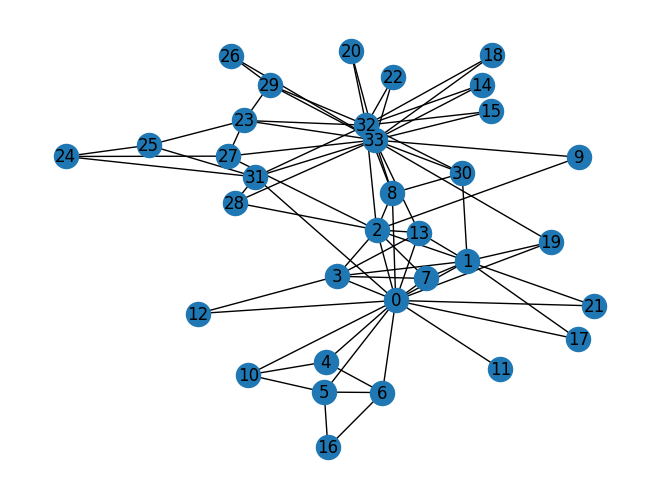

In [3]:
import networkx as nx
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 载入空手道俱乐部网络
G = nx.karate_club_graph()
# 可视化图
nx.draw(G, with_labels=True)

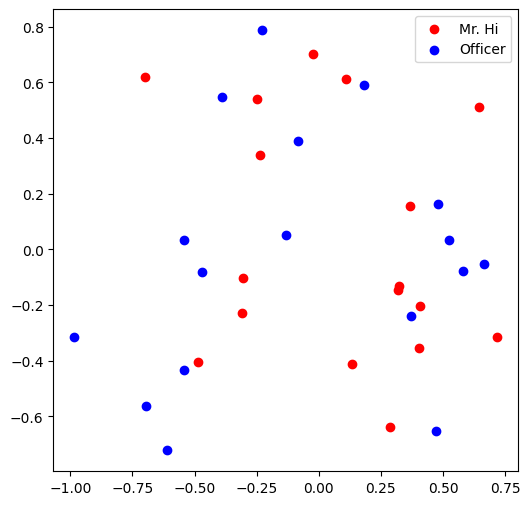

In [4]:
torch.manual_seed(1)


# 初始化嵌入函数
def create_node_emb(num_node=34, embedding_dim=16):
    emb = nn.Embedding(num_node, embedding_dim)  # 创建 Embedding
    emb.weight.data = torch.rand(num_node, embedding_dim)  # 均匀初始化
    return emb


# 初始化嵌入
emb = create_node_emb()


# 可视化
def visualize_emb(emb):
    X = emb.weight.data.numpy()
    pca = PCA(n_components=2)
    components = pca.fit_transform(X)
    plt.figure(figsize=(6, 6))
    club1_x = []
    club1_y = []
    club2_x = []
    club2_y = []
    for node in G.nodes(data=True):
        if node[1]["club"] == "Mr. Hi":
            # node的形式：第一个元素是索引，第二个元素是attributes字典
            club1_x.append(components[node[0]][0])
            club1_y.append(components[node[0]][1])
            # 这里添加的元素就是节点对应的embedding经PCA后的两个维度
        else:
            club2_x.append(components[node[0]][0])
            club2_y.append(components[node[0]][1])
    plt.scatter(club1_x, club1_y, color="red", label="Mr. Hi")
    plt.scatter(club2_x, club2_y, color="blue", label="Officer")
    plt.legend()
    plt.show()


# 可视化初始嵌入
visualize_emb(emb)

In [5]:
def graph_to_edge_list(G):
    # 将 tensor 变成 edge_list

    edge_list = []

    for edge in G.edges():
        edge_list.append(edge)

    return edge_list


def edge_list_to_tensor(edge_list):
    # 将 edge_list 变成 tesnor

    edge_index = torch.tensor([])

    edge_index = torch.LongTensor(edge_list).t()

    return edge_index


pos_edge_list = graph_to_edge_list(G)
pos_edge_index = edge_list_to_tensor(pos_edge_list)
print("The pos_edge_index tensor has shape {}".format(pos_edge_index.shape))
print("The pos_edge_index tensor has sum value {}".format(torch.sum(pos_edge_index)))

The pos_edge_index tensor has shape torch.Size([2, 78])
The pos_edge_index tensor has sum value 2535


In [6]:
import random


# 采样负边
def sample_negative_edges(G, num_neg_samples):

    neg_edge_list = []

    # 得到图中所有不存在的边（这个函数只会返回一侧，不会出现逆边）
    non_edges_one_side = list(enumerate(nx.non_edges(G)))
    neg_edge_list_indices = random.sample(
        range(0, len(non_edges_one_side)), num_neg_samples
    )
    # 取样num_neg_samples长度的索引
    for i in neg_edge_list_indices:
        neg_edge_list.append(non_edges_one_side[i][1])

    return neg_edge_list


# Sample 78 negative edges
neg_edge_list = sample_negative_edges(G, len(pos_edge_list))

# Transform the negative edge list to tensor
neg_edge_index = edge_list_to_tensor(neg_edge_list)
print("The neg_edge_index tensor has shape {}".format(neg_edge_index.shape))

The neg_edge_index tensor has shape torch.Size([2, 78])


loss_result 1.9238824844360352
Accuracy 0.5
loss_result 1.4553194046020508
Accuracy 0.5
loss_result 0.9098954796791077
Accuracy 0.5128
loss_result 0.6537455320358276
Accuracy 0.5833
loss_result 0.5552873611450195
Accuracy 0.6859
loss_result 0.5057224631309509
Accuracy 0.7821
loss_result 0.4689090847969055
Accuracy 0.8269
loss_result 0.4356924295425415
Accuracy 0.859
loss_result 0.40396857261657715
Accuracy 0.8718
loss_result 0.3732355237007141
Accuracy 0.891
loss_result 0.34342697262763977
Accuracy 0.9487
loss_result 0.31467893719673157
Accuracy 0.9744
loss_result 0.28723010420799255
Accuracy 0.9808
loss_result 0.26133993268013
Accuracy 0.9872
loss_result 0.2372267246246338
Accuracy 0.9872
loss_result 0.21503135561943054
Accuracy 1.0
loss_result 0.1948062628507614
Accuracy 1.0
loss_result 0.1765221804380417
Accuracy 1.0
loss_result 0.16008801758289337
Accuracy 1.0
loss_result 0.14537416398525238
Accuracy 1.0
loss_result 0.13223311305046082
Accuracy 1.0
loss_result 0.12051420658826828
A

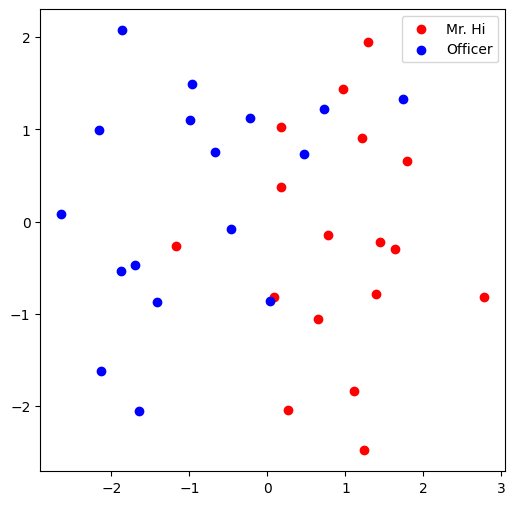

In [7]:
from torch.optim import SGD
import torch.nn as nn


def accuracy(pred, label):
    # 题目要求：
    # 输入参数：
    #  pred (the resulting tensor after sigmoid)
    #  label (torch.LongTensor)
    # 预测值大于0.5被分类为1，否则就为0
    # 准确率返回值保留4位小数

    # accuracy=预测与实际一致的结果数/所有结果数
    # pred和label都是[78*2=156]大小的Tensor
    accu = round(((pred > 0.5) == label).sum().item() / (pred.shape[0]), 4)
    return accu


def train(emb, loss_fn, sigmoid, train_label, train_edge):
    # 题目要求：
    # 用train_edge中的节点获取节点嵌入
    # 点乘每一点对的嵌入，将结果输入sigmoid
    # 将sigmoid输出输入loss_fn
    # 打印每一轮的loss和accuracy

    epochs = 500
    learning_rate = 0.1

    optimizer = SGD(emb.parameters(), lr=learning_rate, momentum=0.9)

    for i in range(epochs):
        optimizer.zero_grad()
        train_node_emb = emb(train_edge)  # [2,156,16]
        # 156是总的用于训练的边数，指78个正边+78个负边
        dot_product_result = train_node_emb[0].mul(
            train_node_emb[1]
        )  # 点对之间对应位置嵌入相乘，[156,16]
        dot_product_result = torch.sum(
            dot_product_result, 1
        )  # 加起来，构成点对之间向量的点积，[156]
        sigmoid_result = sigmoid(
            dot_product_result
        )  # 将这个点积结果经过激活函数映射到0,1之间
        loss_result = loss_fn(sigmoid_result, train_label)
        loss_result.backward()
        optimizer.step()
        if i % 10 == 0:
            print(f"loss_result {loss_result}")
            print(f"Accuracy {accuracy(sigmoid_result,train_label)}")


loss_fn = nn.BCELoss()
sigmoid = nn.Sigmoid()

# 生成正负样本标签
pos_label = torch.ones(
    pos_edge_index.shape[1],
)
neg_label = torch.zeros(
    neg_edge_index.shape[1],
)

# 拼接正负样本标签
train_label = torch.cat([pos_label, neg_label], dim=0)

# 拼接正负样本
# 因为数据集太小，我们就全部作为训练集
train_edge = torch.cat([pos_edge_index, neg_edge_index], dim=1)

train(emb, loss_fn, sigmoid, train_label, train_edge)

# 训练后可视化
visualize_emb(emb)